# Episode-2

    0 : land_x 0, land_y 100
    1 : land_x 1000, land_y 500
    2 : land_x 1500, land_y 1500
    3 : land_x 3000, land_y 1000
    4 : land_x 4000, land_y 150
    5 : land_x 5500, land_y 150
    6 : land_x 6999, land_y 800
    

In [1]:
%pylab
# import numpy as np
from typing import List, Optional, Callable, Tuple, Dict, Union  # OneNote2021 #_python_ #_typing_
GENE = List[int]  # (rotate (-15 ~ +15),power (-1, 0, +1)) 避免無用的值域，下給 Web site 的 command 要轉換成 (rotate(-90 ~ +90), power(0,1,2,3,4))
GENOME = List[GENE]  # Genome 是一個 list 裡面都是 int
STATE = Dict[str,Union[int,float,np.array]]  # x,y,hspeed,power,.. etc 

# Get modules and peforth tools
import random, json, math, copy
from itertools import permutations  # permutations 數學「排列組合」中的「排列」
import IPython

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# 抓進 peforth 以及外加功能
%run forth.py

reDef unknown
reDef -->
p e f o r t h    v1.26
source code http://github.com/hcchengithub/peforth
Type 'peforth.ok()' to enter forth interpreter, 'exit' to come back.



### 兩線相交的偵測程式

In [3]:
# path 太長好像 %run 不了，先到當地去 "subst g: . " 把整條 path 變成 x: 就好辦了
# doIntersect(p1:Vector, q1:Vector, p2:Vector, q2:Vector) -> boolean

# !subst x: /d
# !subst x: "c:\Users\8304018\OneDrive\文件\Jupyter Notebooks\Differences of np.dot and np.multiply"
%run x:\How_to_check_if_two_line_segments_intersect.ipynb

### 點到線段的距離

In [4]:
# Calculate the euclidian distance between an array of points to a line segment in Python without for loop
# https://stackoverflow.com/questions/54442057/calculate-the-euclidian-distance-between-an-array-of-points-to-a-line-segment-in
# OneDrive/文件/Jupyter Notebooks/Differences of np.dot and np.multiply/intro_2_vector.ipynb
# lineseg_dists(p:[Vector], a:Vector, b:Vector) -> [float]

def lineseg_dists(p, a, b):
    # where p is an array of points, a,b is the line segment
    # lineseg_dists(p:[Vector], a:Vector, b:Vector) -> [float]
    
    if np.all(a == b):
        return np.linalg.norm(p - a, axis=1)  # a-b 是一個點，直接取 p-a 就是答案。 p 

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)  # a-p 在 d 上的投影
    t = np.dot(p - b, d)  # p-b 在 d 上的投影

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(p))])  # h 是
    
    # perpendicular distance component, as before
    # note that for the 3D case these will be vectors
    c = np.cross(p - a, d)

    # use hypot for Pythagoras to improve accuracy
    result = np.hypot(h, c)
    
    return result

# 點 [1,1] 在線的右上邊，距離是正的；點 [0,0] 在線的左下邊，距離也是正的，所以它沒有分正負。
p = np.array([[1,1],[0,0]])  # the point
a = np.array([1,0])  # the line start
b = np.array([0,1])  # the line end
distance = lineseg_dists(p, a, b)
%f distance -->

# 這組實驗證實 lineseg_dists() 無誤
p = np.array([[-1,0.5],[0,0],[0,0.5],[0.5,0.5],[1,0],[1,0.5],[2,0.5]])  # the point
a = np.array([0,0])  # the line start
b = np.array([1,0])  # the line end
distance = lineseg_dists(p, a, b)
%f distance -->

distance --> [0.70710678 0.70710678] (<class 'numpy.ndarray'>)
distance --> [1.11803399 0.         0.5        0.5        0.         0.5
 1.11803399] (<class 'numpy.ndarray'>)


# 直接讀 log 檔
So the `%store log` is from here

In [5]:
# Read back the json file which was saved by the above cell.
%f s" episode2-original.json" readTextFile py> eval(pop()) constant log // ( -- json ) "actual free fall.json" log from Codingame > Mars Lander > episode-1 
log = peforth.execute('log').pop()
%f log -->
%store log

log --> [{'step': 0, 'length': 73, 'x': 2500, 'y': 2700, 'hspeed': 0, 'vspeed': 0, 'fuel': 550, 'angle': 0, 'power': 0, 'cmd': [-99, -99]}, {'step': 1, 'length': 73, 'x': 2500, 'y': 2699, 'hspeed': 0, 'vspeed': -3, 'fuel': 549, 'angle': -15, 'power': 1, 'cmd': [-20, 3]}, {'step': 2, 'length': 73, 'x': 2501, 'y': 2695, 'hspeed': 1, 'vspeed': -5, 'fuel': 547, 'angle': -20, 'power': 2, 'cmd': [-20, 3]}, {'step': 3, 'length': 73, 'x': 2502, 'y': 2690, 'hspeed': 2, 'vspeed': -5, 'fuel': 544, 'angle': -20, 'power': 3, 'cmd': [-20, 3]}, {'step': 4, 'length': 73, 'x': 2505, 'y': 2684, 'hspeed': 3, 'vspeed': -6, 'fuel': 541, 'angle': -20, 'power': 3, 'cmd': [-20, 3]}, {'step': 5, 'length': 73, 'x': 2508, 'y': 2677, 'hspeed': 4, 'vspeed': -7, 'fuel': 538, 'angle': -20, 'power': 3, 'cmd': [-20, 3]}, {'step': 6, 'length': 73, 'x': 2513, 'y': 2670, 'hspeed': 5, 'vspeed': -8, 'fuel': 535, 'angle': -20, 'power': 3, 'cmd': [-20, 3]}, {'step': 7, 'length': 73, 'x': 2518, 'y': 2661, 'hspeed': 6, 'vspeed

# 最基本的定義 

In [6]:
Gravity = 3.711        # constant on Mars
G = Gravity             # 到了二維以上，重力需轉成向量
Altitude = 150          # altitude of the flat 
VSpeed = 40             # target virtical speed 
HSpeed = 20             # target horizental speed 
fuel0 = 550             # episode-2

land = [
  [   0, 100], # 0
  [1000, 500], # 1
  [1500,1500], # 2
  [3000,1000], # 3
  [4000, 150], # 4 flat ground
  [5500, 150], # 5 flat ground
  [6999, 800], # 6
]    

# Parameters

round_off = 2           # 顯示到小數點以下兩位避免太長


In [7]:

# Vector 比 np.array 好一點在於有 __str__ 可以做 round-off 輸出。

class Vector:
    def __init__(self, x:float,y:float):
        self.x = x
        self.y = y

    def __mul__(self, x:float):
        m = self.v() * x 
        return Vector(*m)  # Vector(m[0], m[1])  np.array 也可以直接 unpack or distructing 
    
    def __add__(self, x):
        m = self.v() + x.v() 
        return Vector(*m)  # Vector(m[0], m[1])  np.array 也可以直接 unpack or distructing 

    def v(self) -> np.array:
        # A vector is a np.array
        return np.array([self.x,self.y])

    def n(self) -> float:
        # norm of a vector is its length
        return np.linalg.norm(self.v())

    def u(self) -> np.array:
        # Shrink the given vector into an unit vector. https://stackoverflow.com/questions/21030391/how-to-normalize-an-array-in-numpy
        return self if round(self.n(),6) == 0. else self.v()/self.n();  # 考慮周詳
    
    def __str__(self) -> str:
        return 'Vec' + str(np.array([round(self.x,round_off),round(self.y,round_off)]))
    
%f Vector :> (3,4) -->
%f Vector :> (3,4).v() -->
%f Vector :> (3,4).x -->
%f Vector :> (3,4).y -->
%f Vector :> (3,4).n() -->
%f Vector :> (3,4).u() -->
%f Vector :> (0.6,0.8).n() -->
%f Vector :> (0.6,0.8)*2 -->    

Vector :> (3,4) --> Vec[3 4] (<class '__main__.Vector'>)
Vector :> (3,4).v() --> [3 4] (<class 'numpy.ndarray'>)
Vector :> (3,4).x --> 3 (<class 'int'>)
Vector :> (3,4).y --> 4 (<class 'int'>)
Vector :> (3,4).n() --> 5.0 (<class 'numpy.float64'>)
Vector :> (3,4).u() --> [0.6 0.8] (<class 'numpy.ndarray'>)
Vector :> (0.6,0.8).n() --> 1.0 (<class 'numpy.float64'>)
Vector :> (0.6,0.8)*2 --> Vec[1.2 1.6] (<class '__main__.Vector'>)


In [8]:
class Angle(Vector):
    def __init__(self, an:float) -> Vector:
        # Convert the given absolute angle in degrees to a unit vector that represents the angle
        v = Vector(math.cos(np.deg2rad(an + 90)), math.sin(np.deg2rad(an + 90)))
        self.x, self.y = v.x, v.y  # 已經是單位向量，無須這樣 v.u()[0], v.u()[1] 

%f Angle :> (-180) :> v() -->
%f Angle :> (-180) -->
%f Angle :> (90)   -->
%f Angle :> (-90)  -->   
%f Angle :> (180)  -->   
%f Angle :> (45)   -->   
%f Angle :> (-45)  -->   
%f Angle :> (-45) type -->   
    

Angle :> (-180) :> v() --> [ 6.123234e-17 -1.000000e+00] (<class 'numpy.ndarray'>)
Angle :> (-180) --> Vec[ 0. -1.] (<class '__main__.Angle'>)
Angle :> (90)   --> Vec[-1.  0.] (<class '__main__.Angle'>)
Angle :> (-90)  --> Vec[1. 0.] (<class '__main__.Angle'>)
Angle :> (180)  --> Vec[-0. -1.] (<class '__main__.Angle'>)
Angle :> (45)   --> Vec[-0.71  0.71] (<class '__main__.Angle'>)
Angle :> (-45)  --> Vec[0.71 0.71] (<class '__main__.Angle'>)
Angle :> (-45) type --> <class '__main__.Angle'> (<class 'type'>)


In [9]:
G = Angle(180) * Gravity  # G = Vector(*(Angle(180).v() * Gravity)) 我有提供 __mul__ 

%f G -->
%f G type --> 


G --> Vec[-0.   -3.71] (<class '__main__.Vector'>)
G type --> <class '__main__.Vector'> (<class 'type'>)


In [10]:

# State 的 properties 都用 python 的原型，不用 np.array 之類。原因，感覺較單純不會有意外。

class State():

    def __init__(self, step=0, x=2500, y=2700, hspeed=0, vspeed=0, 
                 fuel=550, angle=0, power=0, **kwargs):
        self.step   = step
        self.x      = x
        self.y      = y
        self.hspeed = hspeed
        self.vspeed = vspeed
        self.fuel   = fuel
        self.angle  = angle
        self.power  = power
        self.trace  = [[x,y]]
        self.landed = False
        # self.force  = G + Angle(self.angle)*self.power

    def next(self, angle:int, power:int):  
        # input angle,power 都是 offset differential delta 分別屬 -15~15 以及 -1,0,+1 
        assert power in [-1, 0, 1], 'expected input power [-1, 0, +1], given {}'.format(power)
        assert angle in range(-15,16), 'input angle range [-15:16], given {}'.format(angle)
        self.step   += 1
        self.angle  += angle
        self.angle   = -90 if self.angle < -90 else self.angle
        self.angle   =  90 if self.angle > 90 else self.angle
        self.power  += power
        self.power   = 0 if self.power < 0 else self.power
        self.power   = 4 if self.power > 4 else self.power
        self.fuel   -= self.power
     #  self.x       = self.x       # episode-1 不變
     #  self.y       = self.y + self.vspeed + (1/2)*self.force
     #  self.hspeed  = self.hspeed  # episode-1 不變
     #  self.vspeed += self.force
        force = G + Angle(self.angle)*self.power  # force on the ship during this step         
        s0 = Vector(self.hspeed,self.vspeed)
        p0 = Vector(self.x,self.y)
        s1 = s0 + force 
        p1 = p0 + s0 + force*0.5
        self.x, self.y = p1.x, p1.y
        self.hspeed, self.vspeed = s1.x, s1.y
        self.landed = doIntersect(p0,p1,Vector(4000,150),Vector(5500,150))
        self.trace.append([self.x,self.y])
        return self  # 傳回值只是好測試，以便於可以這樣寫： %f state :> next(0,3.711) -->

    def __str__(self):  
        d = copy.deepcopy(self.__dict__)
        return str([{k:int(round(v,0))} for k,v in d.items() if k != 'trace'])

state0 = State(0,2500,2700,0,0,fuel0,0,0)  # episode-2 的起點 state
%f state0 -->

state0 --> [{'step': 0}, {'x': 2500}, {'y': 2700}, {'hspeed': 0}, {'vspeed': 0}, {'fuel': 550}, {'angle': 0}, {'power': 0}, {'landed': 0}] (<class '__main__.State'>)


In [11]:
state = State(**state0.__dict__)
%f state :: next(-15,1) state :: next(-5,1) state :: next(0,1)
for i in range(100):  # 已知不到 100 用 while True 也行，用 for 比較保險
    state.next(0,0)
    if state.landed: 
        %f state -->
        break       

state --> [{'step': 73}, {'x': 5154}, {'y': 122}, {'hspeed': 74}, {'vspeed': -68}, {'fuel': 334}, {'angle': -20}, {'power': 3}, {'landed': 1}] (<class '__main__.State'>)


In [12]:
%f state :> trace[:4] -->

state :> trace[:4] --> [[2500, 2700], [2500.129409522551, 2698.6274629131444], [2500.730248710979, 2694.966581360219], [2502.1861382577217, 2689.943931359259]] (<class 'list'>)


In [13]:
_ = np.array(state.trace)[:4,1]
%f _ -->
_ = np.array(state.trace)[:4,0]
%f _ -->

_ --> [2700.         2698.62746291 2694.96658136 2689.94393136] (<class 'numpy.ndarray'>)
_ --> [2500.         2500.12940952 2500.73024871 2502.18613826] (<class 'numpy.ndarray'>)


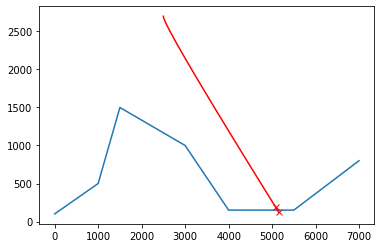

In [14]:
%matplotlib inline
x = [0, 1000, 1500, 3000, 4000, 5500, 6999]
y = [100, 500, 1500, 1000, 150, 150, 800]
# plt.plot(x,y,'',thread[:,0],thread[:,1],'r',thread[-2:,0],thread[-2:,1],'rx');  # 這行等於以下三行，三個 args 一組。
plt.plot(x,y,'')  # 地形
plt.plot(np.array(state.trace)[:,0],np.array(state.trace)[:,1],'r')  # 整條 trace 
plt.plot(np.array(state.trace)[-2:,0],np.array(state.trace)[-2:,1],'rx');  # 最後兩點打上標記


In [15]:
assert False

AssertionError: 

# 來到這裡，手動把 mars lander 的速度跟位置校正到符合標準

In [ ]:
state_a = copy.deepcopy(state)
%f state_a --> # 這時候 vspeed -68 要調回 -40 以內； hspeed 74 要調回 20 以內

In [ ]:
%f state_a :> x -->
%f land :> [4] Vector :> (*pop()).x  -->
%f land :> [5] Vector :> (*pop()).x  -->
state_a.x >= Vector(*land[4]).x and state_a.x <= Vector(*land[5]).x

In [ ]:
%f state_a :> y -->
%f land :> [4] Vector :> (*pop()).y  -->
%f land :> [5] Vector :> (*pop()).y  -->
state_a.y >= Vector(*land[4]).y and state_a.y >= Vector(*land[5]).y

In [ ]:
if state_a.x >= Vector(*land[4]).x and state_a.x <= Vector(*land[5]).x:
%f state_a :> next(0,1) -->

In [ ]:
_ = Vector(*land[4]).y
%f _ -->

In [ ]:
# 全部下 -20,3 取 footprints list
state = State(**state0.__dict__)  # init for ecah genome
footprints = []
%f state :: next(-15,1)
footprints.append([int(round(state.x,0)),int(round(state.y,0))])
%f state :: next(-5,1)
footprints.append([int(round(state.x,0)),int(round(state.y,0))])
%f state :: next(0,1)
footprints.append([int(round(state.x,0)),int(round(state.y,0))])
for i in range(70):
    %f state :: next(0,0)
    footprints.append([int(round(state.x,0)),int(round(state.y,0))])
# %f footprints -->
thread=np.array(footprints)
%f thread :> [0:3] -->
%f ( x ) thread :> [:,0] -->
%f ( y ) thread :> [:,1] -->

In [ ]:
%pylab
%matplotlib inline
x = [0, 1000, 1500, 3000, 4000, 5500, 6999]
y = [100, 500, 1500, 1000, 150, 150, 800]
# plt.plot(x,y,'',thread[:,0],thread[:,1],'r',thread[-2:,0],thread[-2:,1],'rx');  # 這行等於以下三行，三個 args 一組。
plt.plot(x,y,'')  # 地形
plt.plot(thread[:,0],thread[:,1],'r')  # 整條 trace 
plt.plot(thread[-2:,0],thread[-2:,1],'rx');  # 最後兩點打上標記


In [ ]:
for i in range(9):
    state.next(0,0);
    sample_genomes["安全降落"].append([0,0])
for i in range(9,91):
    state.next(0,1);
    sample_genomes["安全降落"].append([0,1])
state_list["安全降落"]=state

In [ ]:
# 改寫 for Mars Lander 乍看以為要頭痛一會兒，其實 Mars Lander 的 genome 很簡單，就是一串 (int,int) 
# pairs 而已。前面基礎討論有提到，以 SA 而言就是 mutate 某一個 gene 也就是 command pair 而已。但是考慮 Mars
# Lander 的限制條件，以 epidode-1 而言，command 的改變要做的決定是 -1 0 +1 其中之一才對，而非 0~4. 

# 長度的問題，
# 太長而無效的 genes 要 cut 掉。
# 長度不夠時直接 copy 最後一個 gene 頂替即可。
# 會發現 genome 太長或不夠的是 simulator 那就是由它處理。

# 1. 避免無效的 neighbour 例如前一 power 是 0 或 4 卻下 -1 或 1 就是無效的，這個 neighbour 就浪費了。 
# 2. 第一個 gene 的 power 不能下 -1 只能下 0 或 +1 , 將來 angle 也有一樣的限制。

def get_random_neighbour(genome: GENOME) -> None :
    neighbour = copy.deepcopy(genome)  # 利用 [:] slice copy 不行！
    commands = genome_to_command_list(neighbour)  # 絕對 command, 用來檢查前一狀態避免產生無效的 neighbour 
    
    while True:  # 試到不一樣了才出來
        idx = random.randint(0,len(genome)-1) # 選 1 個 gene 
        cmd = random.randint(-1, 1)  # -1, 0, +1 當中選 1 個 thrust command (episode-1)
        if idx == 0 and cmd == -1 : continue  # 一開始的 power 就是 0 再下 -1 無效
        if idx >= 1 and cmd == -1 and commands[idx-1][1] == 0: continue  # 前一個 power 就已經是 0 又下 -1 無效
        if idx >= 1 and cmd ==  1 and commands[idx-1][1] == 4: continue  # 前一個 power 就已經是 4 又下 +1 無效
        if neighbour[idx][1] == cmd: continue  # 沒有變化當然無效
        else: 
            neighbour[idx][1] = cmd
            break
            
    return neighbour
%f get_random_neighbour :> ([[0,0],[0,0]]) ( 都不可能出現 -1 ) -->    
%f get_random_neighbour :> ([[0,0],[0,1]]) ( 都不可能出現 -1 ) -->    
%f get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> \ gene0 只有 0 或 1 不會有 -1, gene1 視 gene0 而定     
%f get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> \ gene0 只有 0 或 1 不會有 -1, gene1 視 gene0 而定     
%f get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> \ gene0 只有 0 或 1 不會有 -1, gene1 視 gene0 而定     
%f get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> \ gene0 只有 0 或 1 不會有 -1, gene1 視 gene0 而定     
                             

# Original sample code

#### Surface landscape
    <pre class="stderr" ng-if="::subframe.stderr" ng-bind-html="::subframe.stderr | secureOutput | promptOutput | trustHtml">
    <div class="outputLine">i 0 : land_x 0, land_y 100</div>
    <div class="outputLine">i 1 : land_x 1000, land_y 500</div>
    <div class="outputLine">i 2 : land_x 1500, land_y 1500</div>
    <div class="outputLine">i 3 : land_x 3000, land_y 1000</div>
    <div class="outputLine">i 4 : land_x 4000, land_y 150</div>  取 5000,150 當作目標
    <div class="outputLine">i 5 : land_x 5500, land_y 150</div>
    <div class="outputLine">i 6 : land_x 6999, land_y 800</div>


In [ ]:
import sys
import math

# Auto-generated code below aims at helping you parse
# the standard input according to the problem statement.

surface_n = int(input())  # the number of points used to draw the surface of Mars.
for i in range(surface_n):
    # land_x: X coordinate of a surface point. (0 to 6999)
    # land_y: Y coordinate of a surface point. By linking all the points together in a sequential fashion, you form the surface of Mars.
    land_x, land_y = [int(j) for j in input().split()]
    print('i {} : land_x {}, land_y {}'.format(i, land_x, land_y), file=sys.stderr, flush=True)

# game loop
while True:
    # h_speed: the horizontal speed (in m/s), can be negative.
    # v_speed: the vertical speed (in m/s), can be negative.
    # fuel: the quantity of remaining fuel in liters.
    # rotate: the rotation angle in degrees (-90 to 90).
    # power: the thrust power (0 to 4).
    x, y, h_speed, v_speed, fuel, rotate, power = [int(i) for i in input().split()]

    # Write an action using print
    # To debug: print("Debug messages...", file=sys.stderr, flush=True)


    # rotate power. rotate is the desired rotation angle. power is the desired thrust power.
    print("-20 3")


In [ ]:
def combi(r, n):
    return 1 if n == 0 else combi(r, n - 1) * (r - n + 1) // n
	
height = 13
c = [[combi(r, n) for n in range(r + 1)] for r in range(height)]
 
for r in range(len(c)):
    print(("%" + str((len(c) - r) * 3) + "s") % "", end = "")
    for n in range(len(c[r])):
	    print("%6d" % c[r][n], end = "");
    print()

In [16]:
state = State(**state0.__dict__)
%f state :: next(-15,1) state :: next(-5,1) state :: next(0,1)
for i in range(100):  # 已知不到 100 用 while True 也行，用 for 比較保險
    state.next(0,0)
    %f state -->
    if state.landed: 
        break       

state --> [{'step': 4}, {'x': 2505}, {'y': 2684}, {'hspeed': 3}, {'vspeed': -6}, {'fuel': 541}, {'angle': -20}, {'power': 3}, {'landed': 0}] (<class '__main__.State'>)
state --> [{'step': 5}, {'x': 2508}, {'y': 2677}, {'hspeed': 4}, {'vspeed': -7}, {'fuel': 538}, {'angle': -20}, {'power': 3}, {'landed': 0}] (<class '__main__.State'>)
state --> [{'step': 6}, {'x': 2513}, {'y': 2670}, {'hspeed': 5}, {'vspeed': -8}, {'fuel': 535}, {'angle': -20}, {'power': 3}, {'landed': 0}] (<class '__main__.State'>)
state --> [{'step': 7}, {'x': 2518}, {'y': 2661}, {'hspeed': 6}, {'vspeed': -9}, {'fuel': 532}, {'angle': -20}, {'power': 3}, {'landed': 0}] (<class '__main__.State'>)
state --> [{'step': 8}, {'x': 2525}, {'y': 2651}, {'hspeed': 7}, {'vspeed': -10}, {'fuel': 529}, {'angle': -20}, {'power': 3}, {'landed': 0}] (<class '__main__.State'>)
state --> [{'step': 9}, {'x': 2532}, {'y': 2641}, {'hspeed': 8}, {'vspeed': -11}, {'fuel': 526}, {'angle': -20}, {'power': 3}, {'landed': 0}] (<class '__main__